In [1]:
import ROOT as rt
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [5]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v5/normalized/'

fpath['ee100'] = path + 'ggH_HToSS_SToEE_ms0p1_pl100_1pb_weighted.root'
fpath['ee500'] = path + 'ggH_HToSS_SToEE_ms0p1_pl500_1pb_weighted.root'
fpath['pi100'] = path + 'ggH_HToSS_SToPi0Pi0_ms1_pl100_1pb_weighted.root'
fpath['pi500'] = path + 'ggH_HToSS_SToPi0Pi0_ms1_pl500_1pb_weighted.root'

for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    print(len(tree[k]))

ee100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v5/normalized/ggH_HToSS_SToEE_ms0p1_pl100_1pb_weighted.root
998500
ee500 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v5/normalized/ggH_HToSS_SToEE_ms0p1_pl500_1pb_weighted.root
999400
pi100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v5/normalized/ggH_HToSS_SToPi0Pi0_ms1_pl100_1pb_weighted.root
999400
pi500 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v5/normalized/ggH_HToSS_SToPi0Pi0_ms1_pl500_1pb_weighted.root
999700
CPU times: user 1.48 s, sys: 38.9 ms, total: 1.52 s
Wall time: 7.47 s


# Helper Functions

In [ ]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# Load variables

In [23]:

JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
jetPt_cut = 50
cluster_index = '3'


weight = {}
pileupWeight = {}

evtNum = {}
runNum = {}
lumiSec = {}
sel_ev = {}

gLLP_csc = {}
gLLP_ctau = {}

cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscRechitClusterEta = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterSize = {}
cscRechitClusterAvgStation = {}



for k, T in tree.items():
        
########### SELECTION: CLUSTERS ############
    sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc') == 1

#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0)
#     me1112_veto = 0
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') == 0)

#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') == me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') == me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') == me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
        
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    sel_ev[k] = np.sum(T.array('gLLP_csc'),axis = 1) > 0
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)


#     sel_ev[k]   = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,310]) # MET trigger
#     sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)

#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
#     sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))

########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
    gLLP_csc[k] = T.array('gLLP_csc')[sel_ev[k]]
    weight[k] = T.array('weight')[sel_ev[k]]
    evtNum[k] =  T.array('evtNum')[sel_ev[k]]
    runNum[k] =  T.array('runNum')[sel_ev[k]]
    lumiSec[k] =  T.array('lumiSec')[sel_ev[k]]

    if k[:2] == 'mc':
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]]
    else:
        pileupWeight[k] = np.ones(weight[k].shape, dtype=bool)
    if k[:2] == 'mc':
        weight[k] = weight[k]*lumi

    ##### cluster-level variables ####
    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterX[k] = T.array('cscRechitCluster' + cluster_index + 'X')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterY[k] = T.array('cscRechitCluster' + cluster_index + 'Y')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]].flatten()


## 1D histograms

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


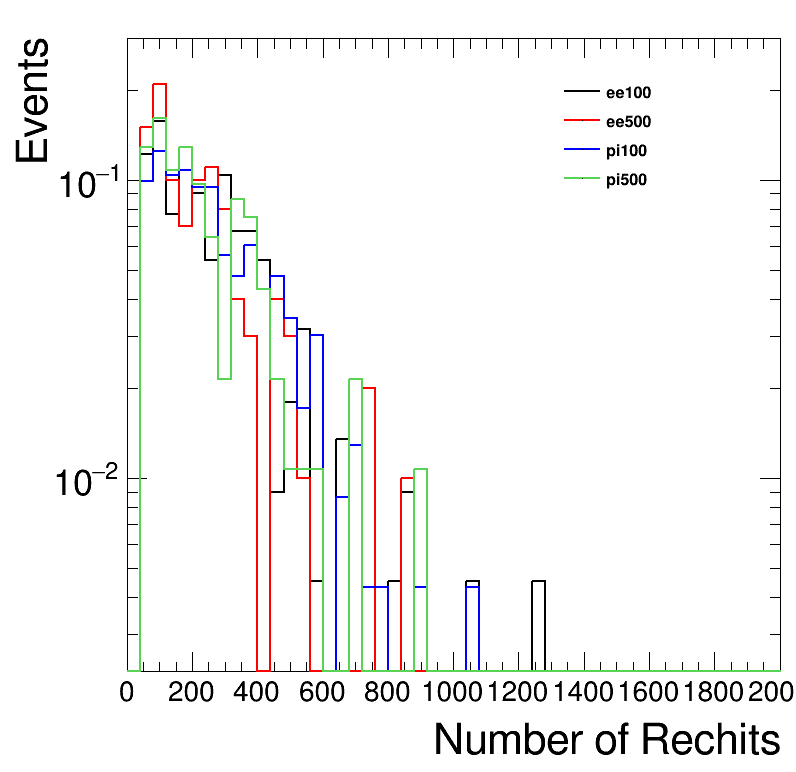

In [20]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}

leg = rt.TLegend(0.7,0.75,0.95,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

for i, k in enumerate(tree.keys()):
    h[k] = create_TH1D( cscRechitClusterSize[k], axis_title=['Number of Rechits', 'Events'], name=k, binning=[50,0,2000])

    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], k)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs()